# Process CAS04 with Remote Reference


This notebook is a companion to the 2024 JOSS manuscript.

This notebook is shows the workflow for getting data from Earthscope for a few example stations and generating transfer functions using aurora.  The data download step is based on condensed version of a tutorial in the mth5 documentation which can be found at: https://github.com/kujaku11/mth5/tree/master/docs/examples/notebooks.  



In [1]:
# %matplotlib notebook 
# %matplotlib widget


In [2]:
#Imports

import pandas as pd
import pathlib
import os
#from aurora.sandbox.mth5_channel_summary_helpers import channel_summary_to_make_mth5
#from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import FDSN
from mth5.utils.helpers import initialize_mth5
from mth5.processing import RunSummary, KernelDataset


In [3]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

# Make MTH5 from IRIS Data Managment Center v0.2.0 

This example demonstrates how to build an MTH5 from data archived at IRIS, it could work with any MT data stored at an FDSN data center (probably).

We will use the `mth5.clients.FDSN` class to build the file.  There is also second way using the more generic `mth5.clients.MakeMTH5` class, which will be highlighted below. 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [4]:
fdsn_object = FDSN(mth5_version='0.2.0')
fdsn_object.client = "IRIS"

## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

In the example below, the stage is set to use two stations: CAS04 and NVR08.  Commented out is an example of how to add a third station, REV06

In [5]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
CAS04 = ["8P", "CAS04",  '2020-06-02T19:00:00', '2020-07-13T19:00:00'] 
NVR08 = ["8P", "NVR08", '2020-06-02T19:00:00', '2020-07-13T19:00:00']
# REV06 = ["8P", "REV06", '2020-06-02T19:00:00', '2020-07-13T19:00:00']

stations = [CAS04, NVR08,]
# stations.append(REV06)

request_list = []
for entry in stations:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_object.request_columns) 
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,NVR08,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,NVR08,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,NVR08,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,NVR08,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,NVR08,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00


In [6]:
%%time

mth5_filename = fdsn_object.make_mth5_from_fdsn_client(request_df)

print(f"Created {mth5_filename}")

2026-01-09T23:24:37.374085-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 140 | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2026-01-09T23:24:37.377045-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 140 | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2026-01-09T23:24:37.388968-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 140 | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2026-01-09T23:24:37.391969-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 140 | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2026-01-09T23:24:37.400654-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 140 | Converting PoleZerosResponseStage electric_si_units to a

In [7]:
mth5_path = pathlib.Path("8P_CAS04_NVR08.h5")

In [8]:
m = initialize_mth5(mth5_path)
m.channel_summary.summarize()
df = m.channel_summary.to_dataframe()
df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Fix Survey Name

- The survey name is extracted from the metadata provided by Earthscope
- The value of the survey name was changed from "CONUS South" to "CONUS SoCal", and the notebook was updated to reflect this, however, as of June 30, 2024, the name seems to have changed back to "CONUS South".
- To avoid problems wiht these change of nomencalature we extract the survey name as a variable

In [9]:
survey_id = df["survey"].unique()[0]
survey_id

'CONUS South'

In [10]:
df.station.unique()

array(['CAS04', 'NVR08'], dtype=object)

In [11]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2026-01-09T23:25:31.380469-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",11266.0,2020-06-02 22:07:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,11267,"[ex, ey, hz]",a,1.0,2020-06-02 19:00:00+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",847648.0,2020-06-12 17:52:23+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,847649,"[ex, ey, hz]",b,1.0,2020-06-02 22:24:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1638042.0,2020-07-01 17:32:59+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1638043,"[ex, ey, hz]",c,1.0,2020-06-12 18:32:17+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1034585.0,2020-07-13 19:00:00+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1034586,"[ex, ey, hz]",d,1.0,2020-07-01 19:36:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
4,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2860.0,2020-06-03 19:57:51+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,2861,"[ex, ey, hz]",a,1.0,2020-06-03 19:10:11+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
5,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",938509.0,2020-06-14 16:56:02+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,938510,"[ex, ey, hz]",b,1.0,2020-06-03 20:14:13+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
6,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",856502.0,2020-06-24 15:55:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,856503,"[ex, ey, hz]",c,1.0,2020-06-14 18:00:44+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>


In [12]:
coverage_short_list_columns = ["survey", 'station', 'run', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

,survey,station,run,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00
4,CONUS South,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00
5,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00
6,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [13]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = "NVR08"
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

2026-01-09T23:25:34.296739-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


,survey,station,run,start,end,duration
0,CONUS South,CAS04,b,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
1,CONUS South,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
2,CONUS South,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
3,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
4,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
5,CONUS South,NVR08,b,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
6,CONUS South,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0
7,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0


In [14]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
cutoff_duration_in_seconds = 180000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

2026-01-09T23:25:35.947637-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


,survey,station,run,start,end
0,CONUS South,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00
3,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [15]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
#                                       emtf_band_file=BANDS_DEFAULT_FILE,)

2026-01-09T23:25:35.988313-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [16]:
config

{
    "processing": {
        "band_setup_file": "C:\\Users\\peaco\\OneDrive\\Documents\\GitHub\\aurora\\aurora\\config\\emtf_band_setup\\bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "channel_nomenclature.keyword": "default",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.119140625,
                                "frequency_min": 0.095703125,
                                "index_max": 30,
                            

In [17]:
for dec_level in config.decimations:
    dec_level.stft.window.type = "hamming"

In [18]:
tf_file_base = f"{station_id}_RR{remote_reference_id}"

2026-01-09T23:25:36.196131-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-09T23:25:36.202014-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
    duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   769090.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256     769090.0            3433.0
1   769090.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000           1024.0                 256     192272.0             858.0


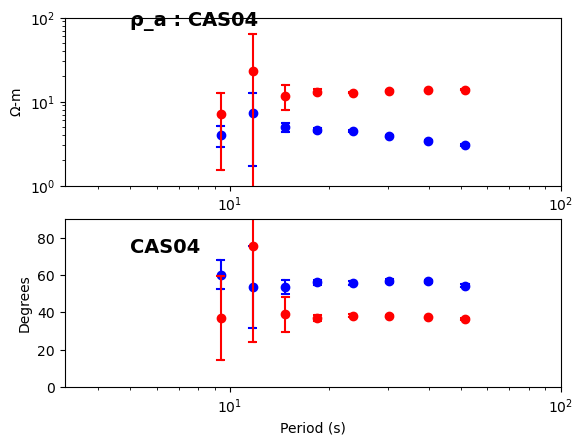

2026-01-09T23:26:28.722877-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 1
2026-01-09T23:26:29.081795-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 1 Successfully
2026-01-09T23:26:31.106687-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:33.157963-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:35.068825-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:37.332475-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc = 

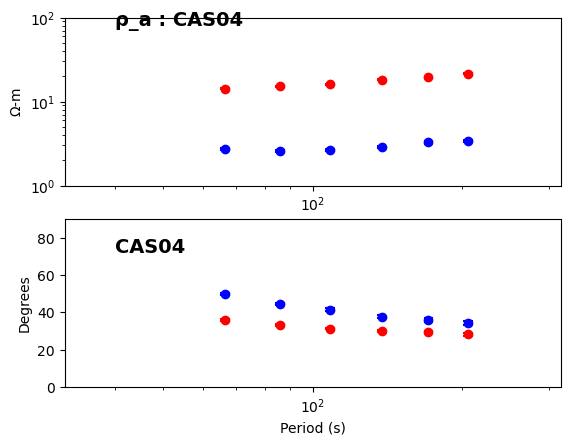

2026-01-09T23:26:40.551529-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 2
2026-01-09T23:26:40.675477-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 2 Successfully
2026-01-09T23:26:42.524287-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:44.477960-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:46.266141-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:48.206663-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc = 

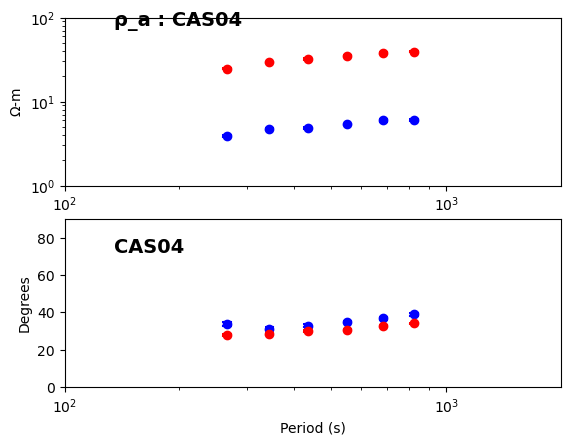

2026-01-09T23:26:51.223164-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 3
2026-01-09T23:26:51.282621-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 3 Successfully
2026-01-09T23:26:53.107158-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:55.110932-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:56.907387-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-09T23:26:58.925025-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc = 

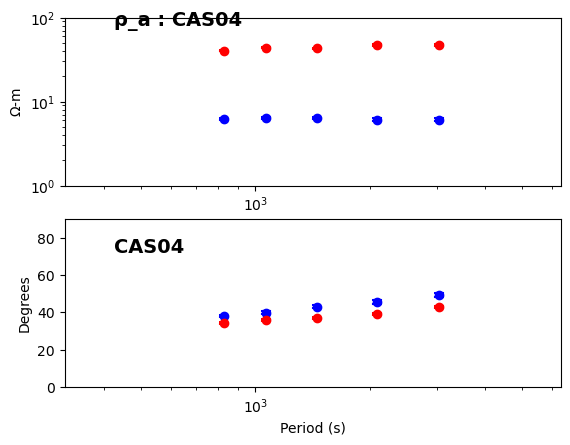

2026-01-09T23:27:01.542261-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 215 | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>
2026-01-09T23:27:01.643078-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 218 | Transfer function object written to CAS04_RRNVR08.zrr
2026-01-09T23:27:01.907521-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5
2026-01-09T23:27:02.184245-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


In [19]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [20]:
tf_cls.write(fn=f"{tf_file_base}.xml", file_type="emtfxml")
tf_cls.write(fn=f"{tf_file_base}.edi", file_type="edi")
tf_cls.write(fn=f"{tf_file_base}.zrr", file_type="zrr")

2026-01-09T23:27:02.268387-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse string null check formatting, should be YYYY-MM-DDThh:mm:ss.ns
2026-01-09T23:27:02.270392-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse string NULL check formatting, should be YYYY-MM-DDThh:mm:ss.ns
2026-01-09T23:27:02.271389-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse string Null check formatting, should be YYYY-MM-DDThh:mm:ss.ns
2026-01-09T23:27:02.271389-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse string null check formatting, should be YYYY-MM-DDThh:mm:ss.ns
2026-01-09T23:27:02.273388-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse string NULL check formatting, should be YYYY-MM-DDThh:mm:ss.ns
2026-01-09T23:27:02.273388-0800 | ERROR | mt_metadata.common.mttime | _parse_string | line: 219 | Could not parse s

MT( station='CAS04', latitude=37.63, longitude=-121.47, elevation=335.26 )

In [21]:
archived_z_file = pathlib.Path(f"CAS04bcd_REV06.zrr")

In [22]:
from aurora.transfer_function.plot.comparison_plots import compare_two_z_files
z_file_path = "CAS04_RRNVR08.zrr"

#  To compare with the archived file, we need to set the coordinate system to geographic

The TF will be output with a header like this:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1    13.20     0.00 CAS04  Hx
    2   103.20     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4    13.20     0.00 CAS04  Ex
    5   103.20     0.00 CAS04  Ey
```

To remove the rotation, we can use a variety of tools, but another way is just to overwrite the orientations:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
 Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1     0.00     0.00 CAS04  Hx
    2    90.00     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4     0.00     0.00 CAS04  Ex
    5    90.00     0.00 CAS04  Ey
```

This is why we set angle1=13.2 degrees in the comparison plotter.

In [23]:
print(z_file_path)
print(archived_z_file)
print(tf_file_base)

CAS04_RRNVR08.zrr
CAS04bcd_REV06.zrr
CAS04_RRNVR08


In [24]:
compare_two_z_files(
    z_file_path,
    archived_z_file,
    angle1=+13.2,
    label1="aurora",
    label2="emtf",
    scale_factor1=1,
    out_file=f"{tf_file_base}compare.png",
    markersize=3,
    rho_ylims=[1e0, 1e3],
    xlims=[0.99, 2000],
    rho_ax_label_size=12,
    phi_ax_label_size=12
)

2026-01-09T23:27:02.985962-0800 | INFO | aurora.transfer_function.plot.comparison_plots | compare_two_z_files | line: 87 | Scaling TF scale_factor1: 1
2026-01-09T23:27:03.749683-0800 | INFO | aurora.transfer_function.plot.comparison_plots | compare_two_z_files | line: 182 | Saved comparison plot to CAS04_RRNVR08compare.png


# Part II: Logic to save FCs

Storage of FCs was intended to be an option to provide to users on the fly, by setting the decimation_level
part of the processing config to `dec_level.save_fcs = True` and `dec_level.save_fcs_type = "h5"`.

This works in some cases but not in general.  Details are in aurora issue #319 https://github.com/simpeg/aurora/issues/319.  

The proposed solution is to generate FCs per station by processing as a single station.

We start with the Run Summary table:

In [25]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2026-01-09T23:27:04.093629-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",11266.0,2020-06-02 22:07:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,11267,"[ex, ey, hz]",a,1.0,2020-06-02 19:00:00+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",847648.0,2020-06-12 17:52:23+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,847649,"[ex, ey, hz]",b,1.0,2020-06-02 22:24:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1638042.0,2020-07-01 17:32:59+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1638043,"[ex, ey, hz]",c,1.0,2020-06-12 18:32:17+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1034585.0,2020-07-13 19:00:00+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1034586,"[ex, ey, hz]",d,1.0,2020-07-01 19:36:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
4,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2860.0,2020-06-03 19:57:51+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,2861,"[ex, ey, hz]",a,1.0,2020-06-03 19:10:11+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
5,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",938509.0,2020-06-14 16:56:02+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,938510,"[ex, ey, hz]",b,1.0,2020-06-03 20:14:13+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
6,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",856502.0,2020-06-24 15:55:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,856503,"[ex, ey, hz]",c,1.0,2020-06-14 18:00:44+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>


### But this time, process stations individually (e.g. CAS04 as below)

In [26]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = None
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

2026-01-09T23:27:05.794209-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


,survey,station,run,start,end,duration
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11266.0
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847648.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1638042.0
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1034585.0


Before adding the FCs, take a look at the file stats:

In [27]:
file_info = os.stat(mth5_path)
print(f"file_info: \n {file_info}")

file_size_before_fc_addition = file_info.st_size
print(f"file_size_before_fc_addition {file_size_before_fc_addition}")

file_info: 
 os.stat_result(st_mode=33206, st_ino=12666373952639373, st_dev=2686700964, st_nlink=1, st_uid=0, st_gid=0, st_size=107445949, st_atime=1768030025, st_mtime=1768030025, st_ctime=1768026132)
file_size_before_fc_addition 107445949


In [28]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
for dec_level in config.decimations:
    dec_level.stft.window.type = "hamming"
#    dec_level.stft.window.overlap = int(dec_level.stft.window.num_samples/4)
    dec_level.save_fcs = True
    dec_level.save_fcs_type = "h5"

2026-01-09T23:27:05.849211-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [29]:
config

{
    "processing": {
        "band_setup_file": "C:\\Users\\peaco\\OneDrive\\Documents\\GitHub\\aurora\\aurora\\config\\emtf_band_setup\\bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "channel_nomenclature.keyword": "default",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.119140625,
                                "frequency_min": 0.095703125,
                                "index_max": 30,
                            

In [30]:
tf_file_base = f"{station_id}_SS"

2026-01-09T23:27:05.975724-0800 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | line: 50 | Window is longer than the time series -- no complete windows can be returned
2026-01-09T23:27:05.982723-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-09T23:27:05.987763-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
     duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0     11266.0      True      11267   a   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256      11266.0              50.0
1     11266.0      True      11267

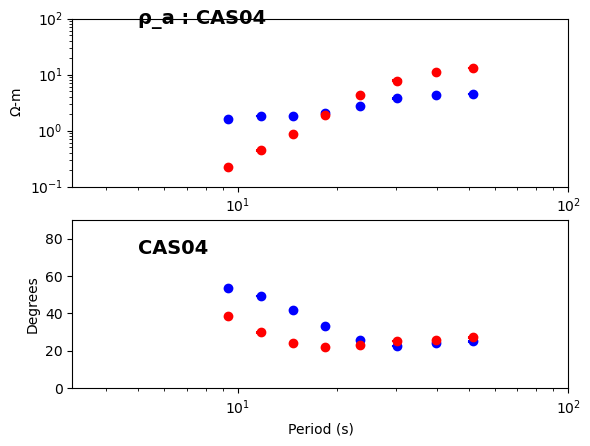

2026-01-09T23:27:53.593631-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 1
2026-01-09T23:27:53.947549-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 1 Successfully
2026-01-09T23:27:55.777353-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 351 | Saving FC level
2026-01-09T23:27:56.005512-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-09T23:27:56.006512-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hy
2026-01-09T23:27:56.007509-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimate

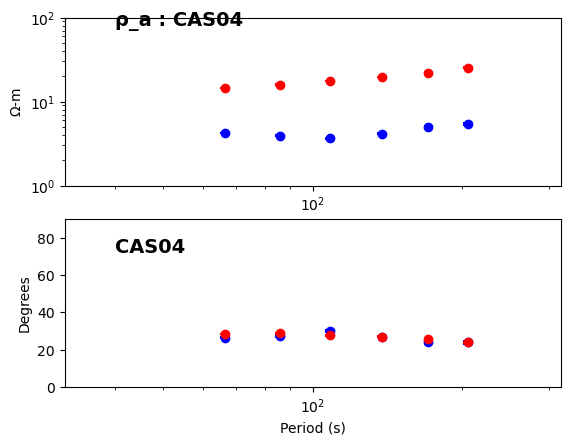

2026-01-09T23:28:05.785250-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 2
2026-01-09T23:28:05.916871-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 2 Successfully
2026-01-09T23:28:07.663096-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 351 | Saving FC level
2026-01-09T23:28:07.886660-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-09T23:28:07.888012-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hy
2026-01-09T23:28:07.889017-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimate

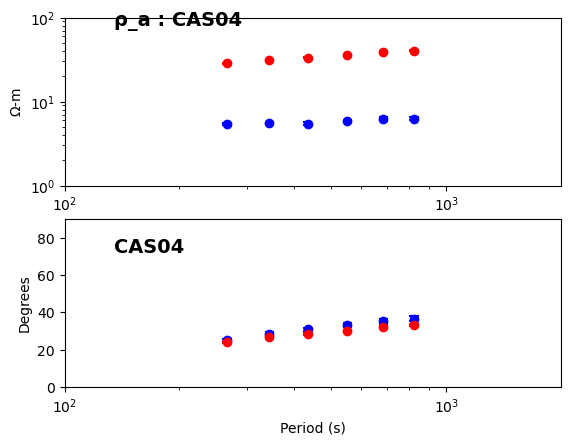

2026-01-09T23:28:17.206995-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 3
2026-01-09T23:28:17.255592-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 3 Successfully
2026-01-09T23:28:19.037123-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 351 | Saving FC level
2026-01-09T23:28:19.258947-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-09T23:28:19.259946-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hy
2026-01-09T23:28:19.259946-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimate

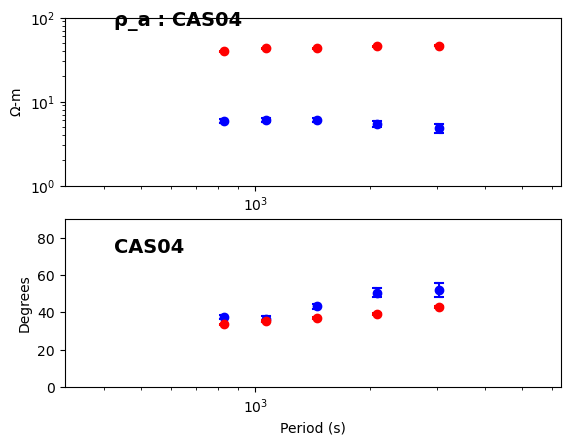

2026-01-09T23:28:25.696235-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 215 | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>
2026-01-09T23:28:25.799959-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 218 | Transfer function object written to CAS04_SS.zrr
2026-01-09T23:28:26.140473-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5


In [31]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [32]:
file_info = os.stat(mth5_path)
print(f"file_info: \n {file_info}")

file_size_after_fc_addition = file_info.st_size
print(f"file_size_before_fc_addition {file_size_before_fc_addition}")
print(f"file_size_after_fc_addition {file_size_after_fc_addition}")

file_info: 
 os.stat_result(st_mode=33206, st_ino=12666373952639373, st_dev=2686700964, st_nlink=1, st_uid=0, st_gid=0, st_size=323345541, st_atime=1768030106, st_mtime=1768030106, st_ctime=1768026132)
file_size_before_fc_addition 107445949
file_size_after_fc_addition 323345541


# Now that the FCs are saved we can access them:|
- These plats are intended to be put in spectrogram class

In [33]:
# Choose what specific FCs we want:
# survey_id = "CONUS SoCal"  # declared directly from dataframe to avoid spurious name changes in archived metadata
station_id = "CAS04"
run_id = "b"
decimation_level_id = "0"

In [34]:
m = initialize_mth5(mth5_path)

In [35]:
survey_group = m.get_survey(survey_id)

In [36]:
station_obj = survey_group.stations_group.get_station(station_id)

In [37]:
fc_group = station_obj.fourier_coefficients_group.get_fc_group(run_id)
fc_decimation_level = fc_group.get_decimation_level(decimation_level_id)
stft_obj = fc_decimation_level.to_xarray()

2026-01-09T23:28:26.484590-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-09T23:28:26.485590-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hy
2026-01-09T23:28:26.486592-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ex
2026-01-09T23:28:26.487734-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hz
2026-01-09T23:28:26.488334-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hx


In [38]:
stft_obj

<xarray.Dataset> Size: 39MB
Dimensions:    (time: 3784, frequency: 128)
Coordinates:
  * time       (time) datetime64[ns] 30kB 2020-06-02T22:24:55 ... 2020-06-12T...
  * frequency  (frequency) float64 1kB 0.0 0.003906 0.007812 ... 0.4922 0.4961
Data variables:
    ex         (time, frequency) complex128 8MB (nan+nanj) ... (-2.5128931147...
    ey         (time, frequency) complex128 8MB (nan+nanj) ... (5.66864644038...
    hx         (time, frequency) complex128 8MB 0j ... (-5.751219590160795e-1...
    hy         (time, frequency) complex128 8MB 0j ... (-7.598330530372965e-1...
    hz         (time, frequency) complex128 8MB 0j ... (-1.1475486199068608e-...

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
ex = stft_obj.ex
ex = ex.dropna(dim="frequency")
ex

<xarray.DataArray 'ex' (time: 3784, frequency: 127)> Size: 8MB
array([[ 2.33773175e-10+2.07646935e-10j, -5.34577391e-10-9.51404075e-10j,
         3.92577454e-10+6.19915018e-12j, ...,
        -6.34912618e-14+2.06284454e-13j, -2.09915877e-13+1.46188046e-14j,
        -1.24789358e-13+1.01531580e-13j],
       [-2.84283068e-11+3.03054379e-10j,  2.77227212e-10+6.70058037e-12j,
        -4.09327502e-10-2.40139621e-10j, ...,
         3.10321134e-13-8.06128471e-14j, -2.09662900e-13-3.22480540e-13j,
         2.38042670e-13-1.98806930e-14j],
       [-6.67050905e-11+1.08889147e-09j, -8.62722508e-11-5.39808423e-10j,
         2.01949608e-10+3.59894037e-10j, ...,
        -5.22547418e-13-2.90663954e-13j, -5.00731594e-13-1.25958752e-13j,
         2.04692210e-13-3.31006389e-14j],
       ...,
       [ 9.86858138e-10-1.38700609e-09j, -5.61396795e-10-6.17883629e-10j,
        -2.93955799e-10+3.63291110e-10j, ...,
        -3.18545852e-15-3.10745005e-13j,  2.63589670e-13+2.59526876e-14j,
        -8.69445908e-14-7.22396455e-14j],
       [ 2.04457409e-10-1.40448536e-10j, -1.69135533e-10+1.40793704e-10j,
         1.04759351e-10-1.29013264e-10j, ...,
        -2.45312899e-14-5.63140758e-14j,  1.19095680e-13-2.44481560e-14j,
         4.32252694e-14-5.56285156e-14j],
       [-5.10286876e-10+1.79023819e-10j,  3.90691276e-10-5.80480204e-10j,
        -3.37564619e-10+3.18932349e-10j, ...,
        -1.39788627e-13+8.20386054e-14j,  1.61237707e-14+7.50618807e-14j,
        -2.51289311e-14+3.39425981e-14j]], shape=(3784, 127))
Coordinates:
  * time       (time) datetime64[ns] 30kB 2020-06-02T22:24:55 ... 2020-06-12T...
  * frequency  (frequency) float64 1kB 0.003906 0.007812 ... 0.4922 0.4961
Attributes:
    component:                     ex
    frequency_max:                 0.49609375
    frequency_min:                 0.0
    sample_rate_decimation_level:  1.0
    sample_rate_window_step:       224.0
    time_period.end:               2020-06-12T17:48:07+00:00
    time_period.start:             2020-06-02T22:24:55+00:00
    units:                         digital counts

In [41]:
ex = np.abs(ex)

In [42]:
ex.time.data

array(['2020-06-02T22:24:55.000000000', '2020-06-02T22:28:39.000000000',
       '2020-06-02T22:32:23.000000000', ...,
       '2020-06-12T17:40:39.000000000', '2020-06-12T17:44:23.000000000',
       '2020-06-12T17:48:07.000000000'],
      shape=(3784,), dtype='datetime64[ns]')

Plotting spectrograms with dates:

The cell below was adapted from:

https://stackoverflow.com/questions/23139595/dates-in-the-xaxis-for-a-matplotlib-plot-with-imshow

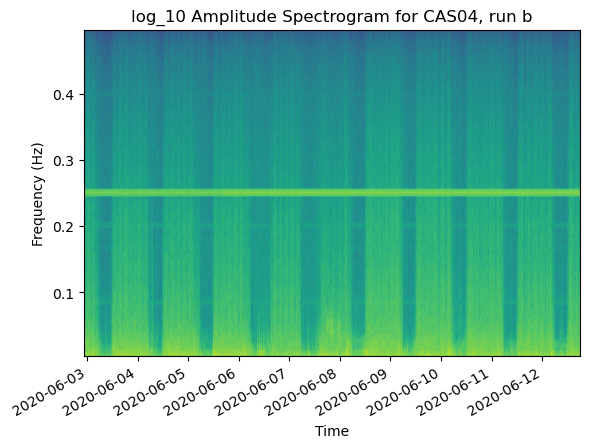

In [43]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import datetime as dt

x_lims = [ex.time.data[0], ex.time.data[-1]]

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

# Set y-limits.
y_lims = [ex.frequency.data[0], ex.frequency.data[-1]]

fig, ax = plt.subplots()

# Using ax.imshow we set two keyword arguments. The first is extent.
# We give extent the values from x_lims and y_lims above.
# We also set the aspect to "auto" which should set the plot up nicely.
ax.imshow(np.log10(ex.T), extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto', origin='lower' )

# # We tell Matplotlib that the x-axis is filled with datetime data, 
# # this converts it from a float (which is the output of date2num) 
# # into a nice datetime string.
ax.xaxis_date()

# # We can use a DateFormatter to choose how this datetime string will look.
# # I have chosen HH:MM:SS though you could add DD/MM/YY if you had data
# # over different days.
date_format = mdates.DateFormatter('%Y-%m-%d')# %H:%M:%S')

ax.xaxis.set_major_formatter(date_format)

# # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title(f"log_{10} Amplitude Spectrogram for {station_id}, run {run_id}")
plt.show()

# Absolute Minimal Example

- This is the code from Figure 3 in the JOSS manuscript intended to show that the processing can be run in 8 lines including saving results to `edi` file format.

In [44]:
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.processing import KernelDataset, RunSummary

In [45]:
run_summary = RunSummary()
run_summary.from_mth5s(["8P_CAS04_NVR08.h5",])
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04", "NVR08")
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf = process_mth5(config, kernel_dataset)
tf.write(fn="CAS04_rrNVR08.edi", file_type="edi")

2026-01-09T23:28:27.317881-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5
2026-01-09T23:28:29.166535-0800 | INFO | mth5.mth5 | close_mth5 | line: 772 | Flushing and closing 8P_CAS04_NVR08.h5
2026-01-09T23:28:29.199386-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE
2026-01-09T23:28:29.229694-0800 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | line: 50 | Window is longer than the time series -- no complete windows can be returned
2026-01-09T23:28:29.229694-0800 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | line: 50 | Window is longer than the time series -- no complete windows can be returned
2026-01-09T23:28:29.237935-0800 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | line: 50 | Window is longer than the time series -- no complete 

Station: CAS04
--------------------------------------------------
	Survey:        CONUS South
	Project:       USMTArray
	Acquired by:   
	Acquired date: 2020-06-02T18:41:43+00:00
	Latitude:      37.633
	Longitude:     -121.468
	Elevation:     335.262
	Impedance:     True
	Tipper:        True
	Number of periods: 25
		Period Range:   9.36498E+00 -- 3.02940E+03 s
		Frequency Range 3.30098E-04 -- 1.06781E-01 s